In [1]:
from glob import glob
import os
import itertools
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import ImageGrid, make_axes_locatable, host_subplot
import matplotlib.ticker as ticker
from matplotlib.collections import Collection, LineCollection
from matplotlib.artist import allow_rasterization
from matplotlib.font_manager import FontProperties
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.dates as md
import matplotlib.ticker as ticker
from metpy.plots import ctables
#from pyPIPS import disdrometer_module as dis
from pyPIPS import pips_io as pipsio
from pyPIPS import timemodule as tm
from pyPIPS.utils import mtokm, getTimeWindow, interp_along_1D
from pyPIPS import plotmodule as pm
from pyPIPS import PIPS as pips
from pyPIPS import fmcw
from itertools import cycle
import netCDF4 as netcdf
from datetime import datetime, timedelta
import pandas as pd
import xarray as xr
from skimage.restoration import unwrap_phase
import skimage.feature as SF
import numpy.ma as ma
from scipy import ndimage, interpolate
%load_ext autoreload
%autoreload 2


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
fmcw_data_dir = '/Users/dawson29/sshfs_mounts/depot_robin/share/VORTEX-SE/2017/data/radar/umassfmcw/nc'
starttimestring = '201704302000'
endtimestring = '201704302359'

filepaths = fmcw.get_fmcw_filepaths(fmcw_data_dir, starttimestring, endtimestring, subdirs=False)
print(filepaths)

['/Users/dawson29/sshfs_mounts/depot_robin/share/VORTEX-SE/2017/data/radar/umassfmcw/nc/S20170430T220104.nc', '/Users/dawson29/sshfs_mounts/depot_robin/share/VORTEX-SE/2017/data/radar/umassfmcw/nc/S20170430T200333.nc', '/Users/dawson29/sshfs_mounts/depot_robin/share/VORTEX-SE/2017/data/radar/umassfmcw/nc/S20170430T230458.nc', '/Users/dawson29/sshfs_mounts/depot_robin/share/VORTEX-SE/2017/data/radar/umassfmcw/nc/S20170430T210037.nc']


In [3]:
# Read in multifile FMCW dataset
fmcw_merged_dataset = fmcw.read_fmcw_multifile_xarray(filepaths)
# Dealias
fmcw_merged_dataset = fmcw.dealias(fmcw_merged_dataset)
fmcw_merged_dataset.load()
print(fmcw_merged_dataset)

/Users/dawson29/Projects/pyPIPS/pyPIPS/fmcw.py:169: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  fmcw_dataset = xr.open_mfdataset(filelist, preprocess=preprocess_fmcw_xarray)
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: The datasets supplied do not have global dimension coordinates. In
future, to continue concatenating without supplying dimension
coordinates, please use the new `combine_nested` function (or the
`combine='nested'` option to open_mfdataset.
  from_openmfds=True,


<xarray.Dataset>
Dimensions:  (height: 1024, time: 1112, vels: 256)
Coordinates:
  * height   (height) float64 1.0 5.0 10.0 15.0 ... 5.105e+03 5.11e+03 5.115e+03
  * time     (time) datetime64[ns] 2017-04-30T20:03:45 ... 2017-05-01T00:00:46
  * vels     (vels) float32 -7.314703 -7.257557 ... 7.2004104 7.257557
Data variables:
    Zef      (time, height, vels) float64 -99.0 -99.0 -99.0 ... -99.0 -45.9
    sf       (time, height, vels) int16 -290 -269 -252 -261 ... -378 -393 -371
    sn       (time, height) int16 -252 -269 -284 -289 ... -373 -372 -372 -373
    sff      (time, height, vels) int16 -290 -269 -252 -261 ... -378 -393 -371
    snr      (time, height) float64 13.6 11.1 -1.9 -14.2 ... 0.6 0.8 0.5 0.5
    Ze       (time, height) float64 -68.3 -56.8 -64.0 -72.7 ... -7.0 -7.3 -7.3
    vel      (time, height) float32 -2.4618998e-07 4.580443 ... -0.11266704
    wid      (time, height) float32 5.0565834 4.812201 ... 2.9851758 2.9889407
    vel_da   (time, height) float64 nan nan nan .

In [4]:
# Read in PIPS data
PIPS_data_dir = '/Volumes/scr_fast/Projects/VORTEXSE/obsdata/full_PIPS_dataset/SATP_retr/'
PIPS_filename = 'parsivel_combined_FMCW_2017_043017_PIPS2A_60s.nc'
PIPS_filepath = os.path.join(PIPS_data_dir, PIPS_filename)
PIPS_ds = xr.open_dataset(PIPS_filepath)
print(PIPS_ds)

<xarray.Dataset>
Dimensions:                   (diameter_bin: 32, fallspeed_bin: 32, fields_KHTX: 21, parameter: 3, time: 301)
Coordinates:
  * time                      (time) datetime64[ns] 2017-04-30T19:00:03 ... 2017-05-01T00:00:03
    fallspeed                 (fallspeed_bin) float64 ...
    diameter                  (diameter_bin) float64 ...
    min_diameter              (diameter_bin) float64 ...
    max_diameter              (diameter_bin) float64 ...
    min_fallspeeds            (fallspeed_bin) float64 ...
    max_fallspeeds            (fallspeed_bin) float64 ...
  * parameter                 (parameter) object 'N0' 'lamda' 'alpha'
  * fields_KHTX               (fields_KHTX) object 'SW' 'mu' ... 'N0' 'D0'
Dimensions without coordinates: diameter_bin, fallspeed_bin
Data variables:
    precipintensity           (time) float64 ...
    precipaccum               (time) float64 ...
    parsivel_dBZ              (time) float64 ...
    pcount                    (time) int64 ...
    

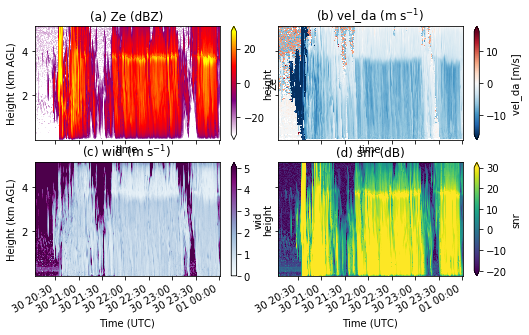

In [5]:
%matplotlib inline
# plt.rcParams["figure.figsize"] = (20,10)
fmcw.plot_fmcw_4panel_xarray(fmcw_merged_dataset)

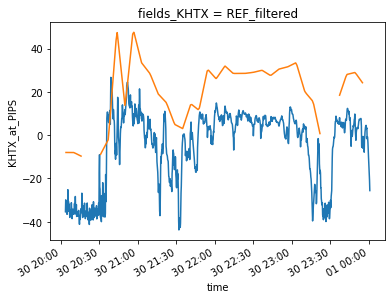

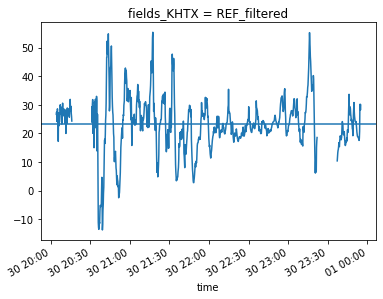

In [6]:
fmcw_merged_dataset = fmcw.correct_fmcw_with_nexrad(fmcw_merged_dataset, PIPS_ds, radar_name='KHTX', plot=True)

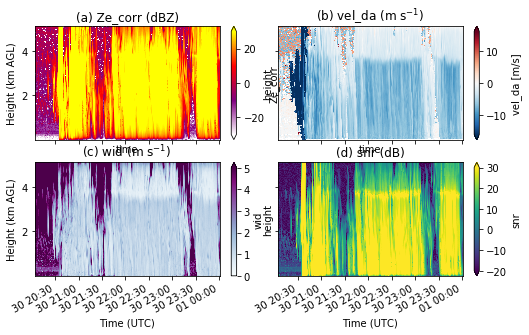

In [7]:
fmcw.plot_fmcw_4panel_xarray(fmcw_merged_dataset, dBZ_var='Ze_corr')

In [8]:
print(fmcw_merged_dataset)

<xarray.Dataset>
Dimensions:   (height: 1024, time: 1112, vels: 256)
Coordinates:
  * height    (height) float64 1.0 5.0 10.0 ... 5.105e+03 5.11e+03 5.115e+03
  * time      (time) datetime64[ns] 2017-04-30T20:03:45 ... 2017-05-01T00:00:46
  * vels      (vels) float32 -7.314703 -7.257557 ... 7.2004104 7.257557
Data variables:
    Zef       (time, height, vels) float64 -99.0 -99.0 -99.0 ... -99.0 -45.9
    sf        (time, height, vels) int16 -290 -269 -252 -261 ... -378 -393 -371
    sn        (time, height) int16 -252 -269 -284 -289 ... -373 -372 -372 -373
    sff       (time, height, vels) int16 -290 -269 -252 -261 ... -378 -393 -371
    snr       (time, height) float64 13.6 11.1 -1.9 -14.2 ... 0.6 0.8 0.5 0.5
    Ze        (time, height) float64 -68.3 -56.8 -64.0 -72.7 ... -7.0 -7.3 -7.3
    vel       (time, height) float32 -2.4618998e-07 4.580443 ... -0.11266704
    wid       (time, height) float32 5.0565834 4.812201 ... 2.9851758 2.9889407
    vel_da    (time, height) float64 nan n

In [9]:
fmcw_output_dir = '/Volumes/scr_fast/Projects/VORTEXSE/obsdata/2017/FMCW/0430'
if not os.path.exists(fmcw_output_dir):
    os.makedirs(fmcw_output_dir)
fmcw_filename = 'fmcw_merged_corrected_{}_{}.nc'.format(starttimestring, endtimestring)
fmcw_filepath = os.path.join(fmcw_output_dir, fmcw_filename)
fmcw_merged_dataset.to_netcdf(fmcw_filepath)

In [ ]:
import pyPIPS.parsivel_params as pp
import pyPIPS.polarimetric as dp
min_diameter = pp.parsivel_parameters['min_diameter_bins_mm']
max_diameter = pp.parsivel_parameters['max_diameter_bins_mm']
bin_width = max_diameter - min_diameter
avg_diameter = pp.parsivel_parameters['avg_diameter_bins_mm']
min_fall_bins = pp.parsivel_parameters['min_fallspeed_bins_mps']
max_fall_bins = pp.parsivel_parameters['max_fallspeed_bins_mps']
avg_fall_bins = pp.parsivel_parameters['avg_fallspeed_bins_mps']

vd_matrix_da = PIPS_ds['VD_matrix_qc']
ND = PIPS_ds['ND_qc']
logND = np.log10(ND)

# conv_df = pips.calc_thermo(conv_df)
# # empirical_fallspeed = pips.calc_empirical_fallspeed(avg_diameter)
# fallspeed_spectrum = pips.calc_fallspeed_spectrum(avg_diameter, avg_fall_bins, correct_rho=True,
#                                                   rho=conv_df['rho'])
# vd_matrix_da = vd_matrix_da.where(vd_matrix_da > 0.0)
# ND = pips.calc_ND(vd_matrix_da, fallspeed_spectrum, 10.)
# ND = ND.T
# logND = np.log10(ND)
# logND = 

PSD_datetimes = pips.get_PSD_datetimes(vd_matrix_da)
PSD_datetimes_dict = pips.get_PSD_time_bins(PSD_datetimes)

PSD_edgetimes = md.date2num(PSD_datetimes_dict['PSD_datetimes_edges'])
PSD_centertimes = md.date2num(PSD_datetimes_dict['PSD_datetimes_centers'])

# ND = PIPS_dict['ND'].T
# logND = ma.log10(ND)
# DSD_index = PIPS_dict['DSD_index']
# DSD_interval = PIPS_dict['DSD_interval']
# DSD_interval_td = timedelta(seconds=DSD_interval)
# DSD_halfinterval_td = timedelta(seconds=DSD_interval / 2.)

# Determine start and end times/indices for analysis
# PSDtimestamps = PIPS_dict['PSDtimestamps']
# PSDtimestampsnums = md.date2num(PSDtimestamps)

#     plotstarttime = starttime
#     plotstoptime = stoptime

# pstartindex, pstopindex = getTimeWindow(starttimestring, endtimestring, PSDtimestampsnums)

# pstarttime = PSDtimestampsnums[pstartindex]
# pstoptime = PSDtimestampsnums[pstopindex]

# plotstarttime = pstarttime
# plotstoptime = pstoptime

# PSDtimestamps_edge = [x - DSD_interval_td for x in PSDtimestamps]
# # Add an extra 10 sec for the last time bin boundary
# PSDtimestamps_edge.append(PSDtimestamps_edge[-1] + DSD_interval_td)
# PSDtimestamps_avg = [x - DSD_halfinterval_td for x in PSDtimestamps]
# PSDstarttimes = md.date2num(PSDtimestamps_edge[pstartindex:pstopindex + 1])
# PSDmidtimes = md.date2num(PSDtimestamps_avg[pstartindex:pstopindex + 1])

scattfile = '/Users/dawson29/Projects/pyPIPS/tmatrix/FMCW/SCTT_RAIN_fw100.dat'
# Observed DSD: TODO, need to make ND, ND_expDSD, and ND_gamDSD have consistent units!
dualpol_dis = dp.calpolrain(15.0, scattfile, ND, bin_width)
#print(dualpol_dis)
dis_ref = dualpol_dis.get('REF', np.empty((0)))
logND_plot = logND.T
disvars = {'min_diameter': min_diameter, 'PSDstarttimes': PSD_edgetimes,
           'PSDmidtimes': PSD_centertimes, 'logND': logND_plot}
disvars['REF'] = dis_ref

# Quick and dirty rayleigh scattering approximation

M6 = []
print(ND.shape)
for t in range(ND.shape[0]):
    temp_M6 = ((avg_diameter[:] / 1000.)**6.) * (1000. * ND[t, :]) * bin_width[:] / 1000.
    temp_M6 = np.nansum(temp_M6)
    M6.append(temp_M6)

M6 = np.array(M6, dtype=np.float64)
refl_disd = 10.0 * np.log10(1e18 * M6)
#disvars['dBZ'] = refl_disd

# fig, ax = plt.subplots(figsize=(8, 3))

# ax.plot(PSD_centertimes, disvars['dBZ'])

radz = 500. # (m) Height of FMCW gate to plot
radzindex = int(radz/5.)

plotx_rad = fmcw_merged_dataset['time'].values
#dBZ_D_plt = fmcw_merged_dataset['Ze'].values[:, radzindex] + 10.**(2.*7.3/10.)
dBZ_D_plt = fmcw_merged_dataset['Ze_corr'].values[:, radzindex]


print(fmcw_merged_dataset['height'][radzindex])
print(fmcw_merged_dataset['Ze_corr'][:, radzindex])

# fmcw_merged_dataset['Ze'][:, radzindex].plot()

# print(dBZ_D_plt)

radvars = {'radmidtimes': plotx_rad, 'REF': dBZ_D_plt}

# Prepare axis parameters
# timelimits = [md.date2num(datetime.strptime(starttimestring, tm.timefmt3)),
#               md.date2num(datetime.strptime(endtimestring, tm.timefmt3))]
# timelimits = [md.date2num(datetime.strptime('20170430203000', tm.timefmt3)),
#               md.date2num(datetime.strptime('20170430210000', tm.timefmt3))]
# Set up axis parameters
start_time = '20170430200000'
end_time = '20170430235900'
try:
    start_datetime = datetime.strptime(start_time, tm.timefmt3)
    print('start_datetime', start_datetime)
except (ValueError, TypeError):
    start_datetime = PSD_edgetimes[0]
try:
    end_datetime = datetime.strptime(end_time, tm.timefmt3)
    print('end_datetime', end_datetime)
except (ValueError, TypeError):
    end_datetime = PSD_edgetimes[-1]
timelimits = [start_datetime, end_datetime]
diamlimits = [0.0, 9.0]
diamytick = 1.0

locator = md.HourLocator(interval=1)
minorlocator = md.MinuteLocator(byminute=[0,15,30,45])
# minorlocator = md.HourLocator(interval=1)
#dateformat = '%d/%H'
dateformat = '%H:%M'
formatter = md.DateFormatter(dateformat)
axparams = {'majorxlocator': locator, 'majorxformatter': formatter,
            'minorxlocator': minorlocator,
            'axeslimits': [timelimits, diamlimits],
            'majorylocator': ticker.MultipleLocator(base=diamytick),
            'axeslabels': [None, 'D (mm)']}

            # Ok, now we should have everything ready to go to plot the meteograms.
            # Let'er rip!
meteogram_image_dir = './'
dis_plot_name = 'PIPS1A_observed'
pm.plotDSDmeteograms(dis_plot_name, meteogram_image_dir,
                     axparams, disvars, radvars.copy(), close_fig=False)